In [1]:
# !pip install transformers
# !pip install torch
# !pip install sklearn
# !pip install transformers --quiet

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

# Text Processing Libraries
import re
import itertools
import string
import collections
from collections import Counter
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.classify import NaiveBayesClassifier
import nltk

# Ensure necessary NLTK packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


# **Import data**

In [3]:
df = pd.read_csv('/content/df_augmented.csv')

# Show number of data entries
print('Number of data: {}'.format(len(df)))

# Show a few samples
df.sample(5)

Number of data: 15134


,Unnamed: 0,text,type
10182,10182,want finish one topic thoroughly bounce next s...,J
14530,14530,inebriato say know sensor touch something even...,S
8471,8471,either scared bashfully resent shyly want friend,E
5649,5649,cry unmatched cause someone stage exotic say s...,F
6104,6104,rile really difficult time intj friend logical...,F


In [4]:
types = df['type'].unique()
types

array(['T', 'I', 'N', 'F', 'E', 'J', 'P', 'S'], dtype=object)

In [5]:
# encoding personality type
enc = LabelEncoder()
df['type'] = enc.fit_transform(df['type'])

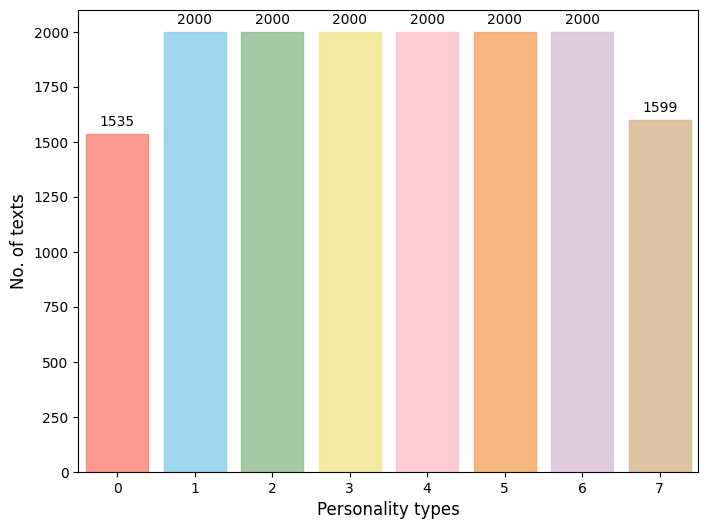

In [6]:
cnt_srs = df['type'].value_counts()
plt.figure(figsize=(8,6))
ax = sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of texts', fontsize=12)

# Show the number of text above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Change the color according to color list
colors = ['salmon', 'skyblue', 'darkseagreen', 'khaki', 'pink', 'sandybrown', 'thistle', 'tan']
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i % len(colors)])

plt.show()

# **Train, valid and test split**

In [7]:
from sklearn.model_selection import train_test_split

# Extra 20% for testing
df_train, df_val = train_test_split(df,
                                    test_size=0.2,
                                    random_state=1,
                                    stratify=df['type'])

Shape: (12107, 3)
Shape: (3027, 3)


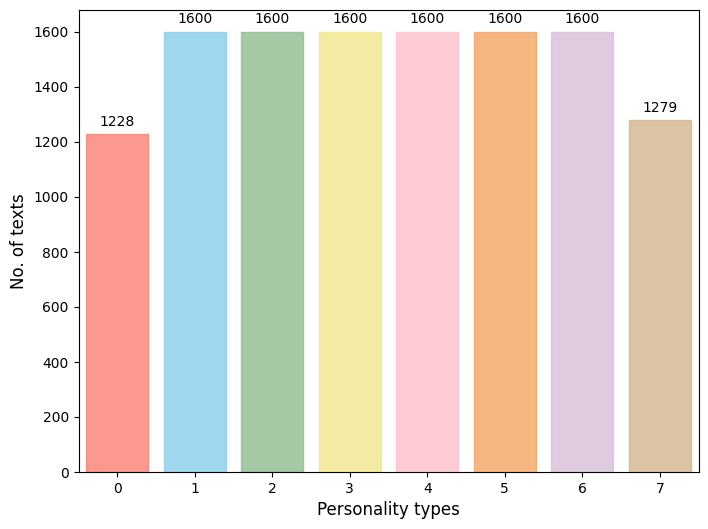

In [8]:
for item in df_train, df_val:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution
cnt_srs = df_train['type'].value_counts()
plt.figure(figsize=(8,6))
ax = sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of texts', fontsize=12)

# Show the number of text above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Change the color according to color list
colors = ['salmon', 'skyblue', 'darkseagreen', 'khaki', 'pink', 'sandybrown', 'thistle', 'tan']
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i % len(colors)])

plt.show()

# **Tokenization**

In [9]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Create lists for encoded text data
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['text']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        max_length=128,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])

    return input_ids, attention_mask

In [11]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):

    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)

    return input_ids, attention_mask

# **Dataset and DataLoader**

In [12]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)

    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['type'].values)

    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)

    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))

    return temp_dataloader

In [13]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# **Import BERT model**

In [14]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=8,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
# Tell mode to use CUDA
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 5

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

# **Training**

In [17]:
# Reset history lists
history_training_loss = []
history_val_loss = []
history_val_acc = []

# Reset history lists
device = torch.device('cuda')
for epoch_i in range(epochs):

    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Training Phase')

    # Set training mode
    model.train()

    # Reset training loss
    total_training_loss = 0.

    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Reset gradients before
        model.zero_grad()

        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)

        loss = res.loss
        logits = res.logits

        # sumup training loss
        total_training_loss += loss.item()

        # backpropagation
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()

    # average loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))

    # append the loss data to history
    history_training_loss.append(avg_train_loss)

    # validation
    print('Validation Phase')

    # Reset validation loss
    total_val_loss = 0

    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)

    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)

    # append validation data to history
    history_val_acc.append(acc)
    history_val_loss.append(avg_val_loss)

    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    print('\n')

【EPOCH: 1/ 5】
Training Phase
  Average training loss: 1.4587
Validation Phase
  Average validation loss: 1.1193
  Validation accruacy: 0.5778


【EPOCH: 2/ 5】
Training Phase
  Average training loss: 0.8304
Validation Phase
  Average validation loss: 0.8364
  Validation accruacy: 0.7070


【EPOCH: 3/ 5】
Training Phase
  Average training loss: 0.4676
Validation Phase
  Average validation loss: 0.7356
  Validation accruacy: 0.7516


【EPOCH: 4/ 5】
Training Phase
  Average training loss: 0.2593
Validation Phase
  Average validation loss: 0.7090
  Validation accruacy: 0.7820


【EPOCH: 5/ 5】
Training Phase
  Average training loss: 0.1626
Validation Phase
  Average validation loss: 0.7032
  Validation accruacy: 0.7783




In [18]:
# Convert histroy to dataframe
cols = ['loss', 'val_loss', 'val_acc']

history = np.stack((
                    np.array(history_training_loss),
                    np.array(history_val_loss),
                    np.array(history_val_acc),
                    ), axis=1)

df_history = pd.DataFrame(history, columns=cols)

# Show df_history
df_history

,loss,val_loss,val_acc
0,1.458721,1.119339,0.577800
1,0.830425,0.836382,0.706971
2,0.467621,0.735617,0.751569
3,0.259335,0.709006,0.781962
4,0.162552,0.703223,0.778328


Text(0.5, 1.0, 'accuracy')

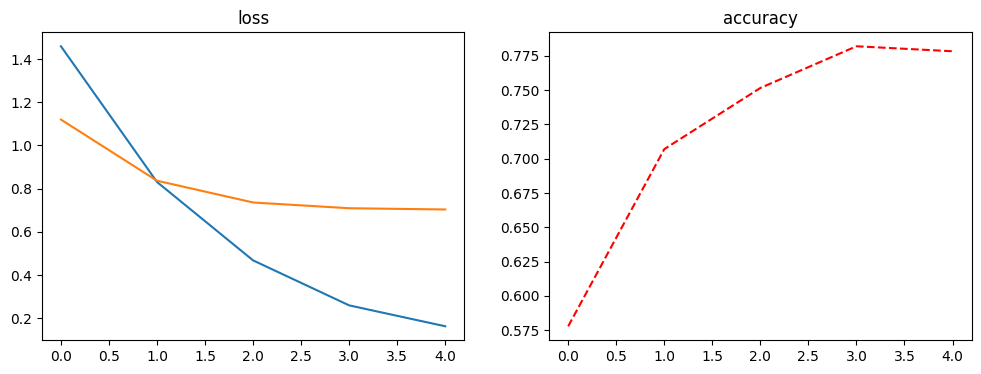

In [19]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_history['loss'])
plt.plot(df_history['val_loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(df_history['val_acc'], color='red', linestyle='--')
plt.title('accuracy')

In [20]:
# Function to map POS (Part-of-Speech) tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif treebank_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif treebank_tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return None  # Return None if no match

# Function to convert verbs to present tense
def convert_to_present_tense(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    converted_tokens = []
    for token, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
        # Lemmatize only if it's a verb
        if wordnet_pos == wordnet.VERB:
            converted_tokens.append(lemmatizer.lemmatize(token, wordnet_pos))
        else:
            converted_tokens.append(token)

    return ' '.join(converted_tokens)

# Basic text preprocessing function
def basic_preprocess(text, remove_special=True):
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)

    # Remove links
    text = re.sub(r'https?:\/\/\S+', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Keep only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove repeating characters (3 or more occurrences)
    text = re.sub(r'([a-z])\1{2,}', r'\1', text)

    # Remove very long words (30+ characters)
    text = re.sub(r'\b\w{30,}\b', ' ', text)

    # Optionally, remove personality-related words
    if remove_special:
        pers_types = ['extrovert', 'introvert', 'ambivert', 'extroverts', 'introverts', 'ambiverts', 'extroverted', 'introverted', 'ambiverted']
        pers_pattern = re.compile(r'\b(' + '|'.join(pers_types) + r')\b', flags=re.IGNORECASE)
        text = pers_pattern.sub('', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Main preprocessing function for a DataFrame
def preprocess_text(df, remove_special=True):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Lemmatize and remove stop words
    def lemmatize_and_remove_stopwords(text):
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
        return " ".join(filtered_tokens)

    # Apply basic preprocessing
    df['text'] = df['text'].astype(str)
    df['text'] = df['text'].apply(lambda x: basic_preprocess(x, remove_special=remove_special))

    # Convert text to present tense
    df['text'] = df['text'].apply(convert_to_present_tense)

    # Lemmatize and remove stop words
    df['text'] = df['text'].apply(lemmatize_and_remove_stopwords)

    return df

In [21]:
def predict_type(text, model, tokenizer, device):
  text_df = pd.DataFrame({'text': [text]})
  processed_text = preprocess_text(text_df)
  processed_text = processed_text['text'].iloc[0]
  encoded = tokenizer.encode_plus(
      processed_text,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      max_length=128,
      return_tensors='pt',
      truncation=True
  )

  input_ids = encoded['input_ids'].to(device)
  attention_mask = encoded['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

  predicted_label = np.argmax(logits.cpu().numpy(), axis=1)[0]
  # print(predicted_label)
  predicted_personality = enc.inverse_transform([predicted_label])[0]
  return predicted_personality

user_text = input("Enter some text: ")
predicted_label = predict_type(user_text, model, tokenizer, device)
print(f"Predicted type: {predicted_label}")

Enter some text: when after hearing a thesis on the connection between quantum physics and the soul you say ""I like to craft""!
Predicted type: S


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
